In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

23/06/08 21:39:58 WARN Utils: Your hostname, codespaces-3c66f5 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/06/08 21:39:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/08 21:39:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
pandas_df = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")

In [5]:
df = spark.createDataFrame(pandas_df)
df.show(10)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1849-01-01|            26.704|                        1.435|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-02-01|            27.434|                        1.362|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-03-01|            28.101|                        1.612|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-04-01|             26.14|           1.3869999999999998|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-05-01|            25.427|                          1.2|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-06-01|            24.844|                        1.402|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-07-01|24.058000000000003|                        1.254|Abidjan|Côte

#### Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [6]:
import pyspark.sql.functions as f

In [7]:
trunc_df = df.filter("dt >= date'1950-01-01'")
print(trunc_df.count())
trunc_df=trunc_df.na.drop()
print(trunc_df.count())
trunc_df.show(10)

76500
76407
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1950-01-01|26.773000000000003|                        0.239|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-02-01|            27.527|                        0.348|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-03-01|            28.344|                        0.431|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-04-01|             27.83|                        0.467|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-05-01|            26.896|                        0.248|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-06-01|            25.454|                        0.209|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-07-01|            24.878|                        0.403|

#### Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

+------------------+----+
|AverageTemperature|Year|
+------------------+----+
| 5.639583333333335|1950|
| 6.259083333333334|1951|
| 7.013416666666667|1952|
|7.5062500000000005|1953|
| 6.243083333333332|1954|
| 6.974750000000001|1955|
| 5.745750000000001|1956|
| 6.424916666666667|1957|
| 5.624333333333333|1958|
| 6.403750000000001|1959|
+------------------+----+
only showing top 10 rows



Text(0.5, 1.0, 'Toronto Average Temperature')

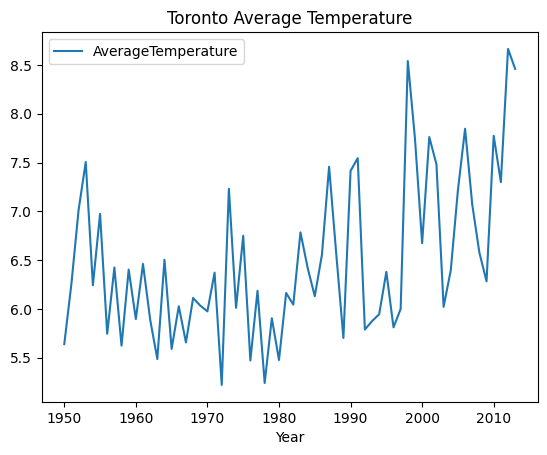

In [8]:
trunc_df.createOrReplaceTempView("temp") 
toronto_temp_data = spark.sql(
    """SELECT AVG(AverageTemperature) as AverageTemperature, 
    EXTRACT(year from `dt`) as Year
    FROM temp
    WHERE City=='Toronto'
    GROUP BY Year
    ORDER BY Year
"""
)
toronto_temp_data.show(10) 
toronto_temp_data.toPandas().set_index("Year").plot() 
plt.title("Toronto Average Temperature")

#### Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [9]:
max_var_city = trunc_df.groupby(trunc_df.City).agg(f.variance("AverageTemperature").alias("Var")).sort(f.desc("Var"))
print(f"The maximum temperature variance was observed in {max_var_city.first().City}: {max_var_city.first().Var:.2f}.")

The maximum temperature variance was observed in Harbin: 218.90.


#### Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

In [10]:
def formatting_latitude(latitude: str) -> float:
    if 'N' in latitude:
        return float(latitude.replace("N", ""))
    elif "S" in latitude:
        return -1 *float(latitude.replace("S", ""))
    else:
        raise ValueError(f"Latitude value is probably malformed: {latitude}")
    
latitude_UDF = f.udf(lambda x:formatting_latitude(x)) 

In [11]:
trunc_df = trunc_df.withColumn("Latitude", latitude_UDF(f.col("Latitude")))
trunc_df = trunc_df.withColumn("Latitude",f.col("Latitude").cast('double'))

In [12]:
jan_expr = "1975-01-(\d+)"
january_df = trunc_df.filter(trunc_df["dt"].rlike(jan_expr))

july_expr = "1975-07-(\d+)"
july_df = trunc_df.filter(trunc_df["dt"].rlike(july_expr))

In [13]:
latitude = trunc_df.groupby(trunc_df.City, trunc_df.Latitude).count().select(trunc_df.City, trunc_df.Latitude)
latitude.show(5)

+---------+--------+
|     City|Latitude|
+---------+--------+
|  Abidjan|    5.63|
|   Berlin|   52.24|
|Changchun|    44.2|
|   Bogotá|    4.02|
|     Cali|    4.02|
+---------+--------+
only showing top 5 rows



In [14]:
joined = max_var_city.join(latitude, ["City"])
joined = joined.select(joined.Var, joined.Latitude)
joined.show(5)

+-------------------+--------+
|                Var|Latitude|
+-------------------+--------+
| 1.8723871715723202|    5.63|
| 49.932927507043665|   52.24|
| 194.60047616720158|    44.2|
|0.39537088651678776|    4.02|
| 0.3961628177471861|    4.02|
+-------------------+--------+
only showing top 5 rows



In [15]:
january_df = january_df.select(january_df.AverageTemperature, january_df.Latitude)
january_df.show(5)

+------------------+--------+
|AverageTemperature|Latitude|
+------------------+--------+
|              26.5|    5.63|
|16.592000000000002|    8.84|
|            18.686|   23.31|
|5.5920000000000005|   36.17|
|            13.806|   31.35|
+------------------+--------+
only showing top 5 rows



In [16]:
july_df = july_df.select(july_df.AverageTemperature, july_df.Latitude)
july_df.show(5)

+------------------+--------+
|AverageTemperature|Latitude|
+------------------+--------+
|            24.647|    5.63|
|            16.456|    8.84|
|            28.713|   23.31|
|            29.414|   36.17|
|            25.774|   31.35|
+------------------+--------+
only showing top 5 rows



In [17]:
import seaborn as sns
sns.set_context("notebook", font_scale=0.9, rc={"figure.figsize": (14, 8)})

In [18]:
joined_pandas = joined.toPandas()
july_df = july_df.toPandas()
january_df = january_df.toPandas()

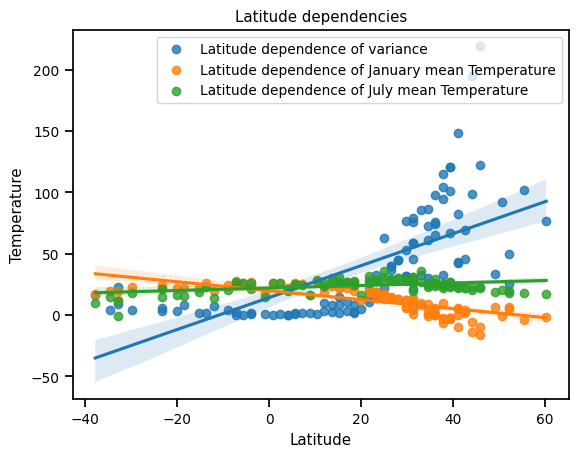

In [19]:
sns.regplot(x="Latitude", y="Var", data=joined_pandas, label="Latitude dependence of variance") 
sns.regplot(x="Latitude", y="AverageTemperature", data=january_df, label="Latitude dependence of January mean Temperature" )
sns.regplot(x="Latitude", y="AverageTemperature", data=july_df, label="Latitude dependence of July mean Temperature")

plt.legend()
plt.title("Latitude dependencies") 
plt.xlabel("Latitude") 
plt.ylabel("Temperature")

plt.show()

#### Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
spb_df = trunc_df.filter(trunc_df.City == "Saint Petersburg")
spb_mean = spb_df.groupBy(f.year("dt").alias("Year")).agg(f.mean("AverageTemperature").alias("Mean Temp per year"))
spb_mean.show()

+----+------------------+
|Year|Mean Temp per year|
+----+------------------+
|1959| 5.026000000000001|
|1990| 5.629416666666668|
|1975| 5.885249999999999|
|1977|3.9462500000000005|
|2003| 4.847416666666667|
|2007| 5.913249999999999|
|1974| 5.642583333333334|
|1955|3.0016666666666665|
|2006| 5.474916666666668|
|1978|2.6957500000000003|
|1961| 5.842083333333334|
|2013| 6.058750000000002|
|1952| 3.749333333333333|
|1956|2.5654999999999997|
|1988| 4.930166666666667|
|1997| 4.668416666666667|
|1994| 4.384333333333333|
|1968|3.4489999999999994|
|1951|           4.30825|
|1973| 4.421500000000001|
+----+------------------+
only showing top 20 rows



In [22]:
from pyspark.sql import Window

In [23]:
w = Window.orderBy("Year")

In [24]:
spb_hotter_than_previous = spb_mean.withColumn("LAG_Column",f.lag("Mean Temp per year", 1).over(w))

In [25]:
spb_hotter_than_previous = spb_hotter_than_previous.na.drop()
spb_hotter_than_previous = spb_hotter_than_previous.filter(spb_hotter_than_previous["Mean Temp per year"] > spb_hotter_than_previous["LAG_Column"])
spb_hotter_than_previous.show()

+----+------------------+------------------+
|Year|Mean Temp per year|        LAG_Column|
+----+------------------+------------------+
|1953| 4.840083333333333| 3.749333333333333|
|1957| 4.856249999999999|2.5654999999999997|
|1959| 5.026000000000001|3.2618333333333336|
|1961| 5.842083333333334| 4.108249999999999|
|1964| 4.414166666666666|3.4835833333333333|
|1967| 4.618666666666667|2.8411666666666666|
|1970| 3.798833333333333| 2.857999999999999|
|1971| 4.157750000000001| 3.798833333333333|
|1972| 5.294333333333333| 4.157750000000001|
|1974| 5.642583333333334| 4.421500000000001|
|1975| 5.885249999999999| 5.642583333333334|
|1977|3.9462500000000005|2.5989166666666668|
|1979|4.0605833333333345|2.6957500000000003|
|1981|            4.3915|3.6558333333333333|
|1982| 4.482166666666667|            4.3915|
|1983| 5.237583333333333| 4.482166666666667|
|1986| 4.054749999999999|2.6400833333333336|
|1988| 4.930166666666667|2.2548333333333335|
|1989| 6.585916666666667| 4.930166666666667|
|1992| 5.4

In [26]:
spb_hotter_than_next = spb_mean.withColumn("LAG_Column",f.lag("Mean Temp per year", -1).over(w))

In [27]:
spb_hotter_than_next = spb_hotter_than_next.na.drop()
spb_hotter_than_next = spb_hotter_than_next.filter(spb_hotter_than_next["Mean Temp per year"] > spb_hotter_than_next["LAG_Column"])
spb_hotter_than_next.show()

+----+------------------+------------------+
|Year|Mean Temp per year|        LAG_Column|
+----+------------------+------------------+
|1950| 4.424083333333334|           4.30825|
|1951|           4.30825| 3.749333333333333|
|1953| 4.840083333333333|             4.454|
|1954|             4.454|3.0016666666666665|
|1955|3.0016666666666665|2.5654999999999997|
|1957| 4.856249999999999|3.2618333333333336|
|1959| 5.026000000000001| 4.108249999999999|
|1961| 5.842083333333334| 4.038250000000001|
|1962| 4.038250000000001|3.4835833333333333|
|1964| 4.414166666666666| 3.702166666666667|
|1965| 3.702166666666667|2.8411666666666666|
|1967| 4.618666666666667|3.4489999999999994|
|1968|3.4489999999999994| 2.857999999999999|
|1972| 5.294333333333333| 4.421500000000001|
|1975| 5.885249999999999|2.5989166666666668|
|1977|3.9462500000000005|2.6957500000000003|
|1979|4.0605833333333345|3.6558333333333333|
|1983| 5.237583333333333| 5.008583333333333|
|1984| 5.008583333333333|2.6400833333333336|
|1986| 4.0

In [28]:
columns = ["Year", "Mean Temp per year"]
spb_hotter_than_next = spb_hotter_than_next.select(columns)
spb_hotter_than_previous = spb_hotter_than_previous.select(columns)

In [29]:
spb_hotter = spb_hotter_than_next.intersect(spb_hotter_than_previous)
spb_hotter.show()

+----+------------------+
|Year|Mean Temp per year|
+----+------------------+
|1953| 4.840083333333333|
|1957| 4.856249999999999|
|1959| 5.026000000000001|
|1961| 5.842083333333334|
|1964| 4.414166666666666|
|1967| 4.618666666666667|
|1972| 5.294333333333333|
|1975| 5.885249999999999|
|1977|3.9462500000000005|
|1979|4.0605833333333345|
|1983| 5.237583333333333|
|1986| 4.054749999999999|
|1989| 6.585916666666667|
|1992| 5.415833333333334|
|1995| 5.422583333333333|
|1997| 4.668416666666667|
|2000| 6.184666666666665|
|2002|           5.07675|
|2005| 5.553249999999999|
|2008| 6.408416666666667|
+----+------------------+
only showing top 20 rows



In [30]:
hot_years = spb_hotter.select('Year').distinct().collect()
hot_years = [row[0] for row in hot_years]

In [31]:
spb_mean_hot_label = spb_mean.withColumn('Hot', f.when(f.col("Year").isin(hot_years), "Hot").otherwise("not hot"))

In [32]:
spb_mean_hot_label.show()

+----+------------------+-------+
|Year|Mean Temp per year|    Hot|
+----+------------------+-------+
|1959| 5.026000000000001|    Hot|
|1990| 5.629416666666668|not hot|
|1975| 5.885249999999999|    Hot|
|1977|3.9462500000000005|    Hot|
|2003| 4.847416666666667|not hot|
|2007| 5.913249999999999|not hot|
|1974| 5.642583333333334|not hot|
|1955|3.0016666666666665|not hot|
|2006| 5.474916666666668|not hot|
|1978|2.6957500000000003|not hot|
|1961| 5.842083333333334|    Hot|
|2013| 6.058750000000002|not hot|
|1952| 3.749333333333333|not hot|
|1956|2.5654999999999997|not hot|
|1988| 4.930166666666667|not hot|
|1997| 4.668416666666667|    Hot|
|1994| 4.384333333333333|not hot|
|1968|3.4489999999999994|not hot|
|1951|           4.30825|not hot|
|1973| 4.421500000000001|not hot|
+----+------------------+-------+
only showing top 20 rows



In [33]:
spb_mean_p = spb_mean.toPandas()
spb_mean_hot_label_p = spb_mean_hot_label.toPandas()


In [34]:
X = spb_mean_p["Year"].array.reshape(-1,1)
y = spb_mean_p["Mean Temp per year"].array.reshape(-1,1)

In [35]:
model = LinearRegression().fit(X,y)

In [36]:
y_pred = model.predict(X)

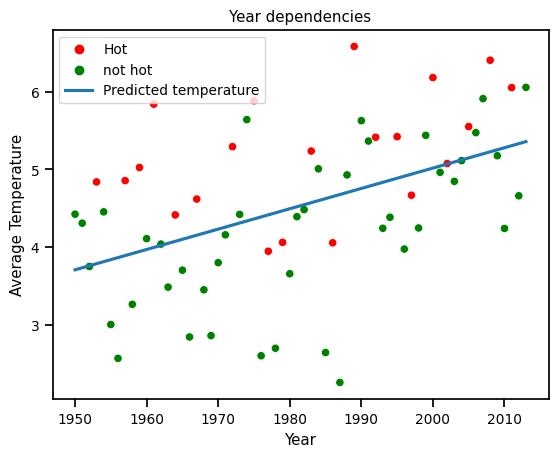

In [37]:
sns.scatterplot(x="Year", y="Mean Temp per year", data=spb_mean_hot_label_p, hue='Hot',palette=['red','green'])
sns.regplot(x=X, y=y_pred, scatter=False, label="Predicted temperature")

plt.legend()
plt.title("Year dependencies") 
plt.xlabel("Year") 
plt.ylabel("Average Temperature")

plt.show()

#### Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [38]:
average_temp_df = trunc_df.groupBy(f.col("City"), f.year("dt").alias("Year")).agg(f.mean("AverageTemperature").alias("Mean Temp per year"))

In [39]:
average_temp_df = average_temp_df.groupBy(f.col("City")).agg((f.max("Mean Temp per year") - f.min("Mean Temp per year")).alias("TempDiff"))
average_temp_df = average_temp_df.sort(f.desc("TempDiff"))
print("Below is list of cities with maximum difference between maximum and minimum temperatures in data:\n")
average_temp_df.show()

Below is list of cities with maximum difference between maximum and minimum temperatures in data:



+----------------+------------------+
|            City|          TempDiff|
+----------------+------------------+
|         Mashhad| 5.250000000000002|
|            Kiev|5.1002083333333355|
|          Moscow| 4.344375000000001|
|Saint Petersburg| 4.331083333333334|
|          Ankara|4.2066666666666706|
|         Baghdad| 3.971916666666665|
|          Harbin| 3.935666666666666|
|        Montreal|3.8666666666666676|
|       Changchun|3.7163333333333344|
|         Taiyuan| 3.695291666666667|
|          Riyadh|3.6393333333333366|
|            Xian| 3.585000000000001|
|          Aleppo|3.5458333333333307|
|         Chicago|3.4469166666666666|
|         Toronto| 3.443083333333335|
|        Tangshan| 3.414291666666669|
|          Berlin|3.3910833333333352|
|         Tianjin|3.2942916666666697|
|          Peking|3.2942916666666697|
|           Paris|3.1896666666666675|
+----------------+------------------+
only showing top 20 rows



In [40]:
average_temp_df = trunc_df.select(f.col("City"), f.year("dt").alias("Year"), f.month("dt").alias("Month"),f.col("AverageTemperature"))

In [41]:
average_temp_df = average_temp_df.filter(f.col("Month").isin([1,7]))
average_temp_df = average_temp_df.groupBy(f.col("City"), f.col("Year"), f.col("Month")).agg(f.mean("AverageTemperature").alias("Mean Temp per Month"))

In [42]:
average_temp_df = average_temp_df.groupBy(f.col("City"), f.col("Year")).agg((f.max("Mean Temp per Month") - f.min("Mean Temp per Month")).alias("Diff"))

In [43]:
average_temp_df = average_temp_df.groupBy(f.col("City")).agg(f.mean("Diff").alias("MeanDiff"))

In [44]:
average_temp_df = average_temp_df.sort(f.desc("MeanDiff"))
print("Below is list of cities with maximum mean difference between mean January temperature and mean July temperature in data:\n")
average_temp_df.show()

Below is list of cities with maximum mean difference between mean January temperature and mean July temperature in data:

+---------+------------------+
|     City|          MeanDiff|
+---------+------------------+
|   Harbin| 41.99271874999997|
|Changchun|39.603718749999985|
| Shenyang|34.927015624999996|
| Montreal|31.169109374999998|
|   Peking|30.658703125000002|
|  Tianjin| 30.65870312499999|
|  Taiyuan|       30.55821875|
| Tangshan|28.636453125000003|
|   Dalian|27.991390624999994|
|    Jinan|27.962015624999996|
|   Moscow| 27.24684375000001|
|  Toronto|      27.221703125|
|    Seoul| 27.15854687500001|
|     Xian|26.707906249999997|
|     Kiev|25.650093749999993|
| New York|25.595109375000007|
|  Baghdad| 25.52635937500001|
|  Nanjing|       25.47228125|
|    Wuhan|25.137640625000003|
| Shanghai|25.005374999999994|
+---------+------------------+
only showing top 20 rows



In [45]:
coolest_months = trunc_df.select(f.col("City"), f.year("dt").alias("Year"), f.month("dt").alias("Month"),f.col("AverageTemperature")).filter(f.col("AverageTemperature") < 0)

In [46]:
coolest_months = coolest_months.groupBy(f.col("City"), f.col("Year")).agg(f.count_distinct("Month").alias("MonthCount"))
coolest_months = coolest_months.groupBy(f.col("City")).agg(f.mean("MonthCount").alias("MeanMonthCount"))
coolest_months = coolest_months.sort(f.desc("MeanMonthCount"))
print("Below is list of cities with maximum mean below zero months amount in data:\n")
coolest_months.show()

Below is list of cities with maximum mean below zero months amount in data:



+----------------+------------------+
|            City|    MeanMonthCount|
+----------------+------------------+
|          Harbin|           4.90625|
|       Changchun|           4.84375|
|          Moscow|          4.546875|
|        Montreal|          4.265625|
|Saint Petersburg|             4.125|
|         Toronto|          3.921875|
|        Shenyang|              3.75|
|            Kiev|          3.359375|
|         Taiyuan|          3.234375|
|          Dalian|              2.75|
|         Tianjin|          2.609375|
|          Peking|          2.609375|
|           Seoul| 2.338709677419355|
|        Tangshan|          2.296875|
|        New York| 2.278688524590164|
|            Xian|1.8548387096774193|
|         Chicago|1.6938775510204083|
|        Santiago|1.5964912280701755|
|          Ankara|1.5813953488372092|
|         Mashhad|              1.52|
+----------------+------------------+
only showing top 20 rows



#### Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

In [47]:
def formatting_longitude(longitude: str) -> float:
    if 'W' in longitude:
        return -1 * float(longitude.replace("W", ""))
    elif "E" in longitude:
        return float(longitude.replace("E", ""))
    else:
        raise ValueError(f"Longitude value is probably malformed: {longitude}")
    
longitude_UDF = f.udf(lambda x:formatting_longitude(x)) 

In [48]:
trunc_df = trunc_df.withColumn("Longitude", longitude_UDF(f.col("Longitude")))
trunc_df = trunc_df.withColumn("Longitude",f.col("Longitude").cast('double'))

In [49]:
columns = ["City", "AverageTemperature", "Latitude", "Longitude"]
january_data = trunc_df.select(f.year("dt").alias("Year"), f.month("dt").alias("Month"), *columns)


In [50]:
january_data = january_data.filter((january_data["Month"]==1) & (january_data["Year"]>(2013-10)))
january_data = january_data.groupBy(f.col("City"), f.col("Latitude"), f.col("Longitude")).agg(f.mean("AverageTemperature").alias("MeanTemp"))
january_data.show()

+-----------+--------+---------+-------------------+
|       City|Latitude|Longitude|           MeanTemp|
+-----------+--------+---------+-------------------+
|    Chicago|   42.59|   -87.27| 0.3448999999999999|
|     Bombay|   18.48|    72.68| 24.824100000000005|
|     Ankara|   39.38|    33.29|-0.6110000000000001|
|Addis Abeba|    8.84|    38.11| 18.223900000000004|
|    Baghdad|   32.95|     45.0| 10.115300000000001|
|     Aleppo|   36.17|    37.79|             5.9257|
|    Abidjan|    5.63|    -3.23| 27.283000000000005|
|  Changchun|    44.2|   125.22|-15.696800000000001|
|     Berlin|   52.24|    13.14|             0.5474|
|       Cali|    4.02|   -76.34| 22.541400000000003|
|      Dakar|   15.27|    -17.5| 22.244300000000003|
|  Bangalore|   12.05|    77.26| 23.564100000000003|
|  Chongqing|   29.74|   107.08| 6.0341000000000005|
|    Bangkok|   13.66|    99.91| 25.754399999999997|
|   Brasília|  -15.27|    -47.5| 22.876800000000003|
|  Cape Town|  -32.95|    18.19| 20.5992000000

In [51]:
import plotly.express as px 
import plotly.graph_objs as go

In [52]:
january_data_p = january_data.toPandas()

In [53]:
january_data_p.head()

,City,Latitude,Longitude,MeanTemp
0,Chicago,42.59,-87.27,0.3449
1,Bombay,18.48,72.68,24.8241
2,Ankara,39.38,33.29,-0.6110
3,Addis Abeba,8.84,38.11,18.2239
4,Baghdad,32.95,45.00,10.1153


In [64]:
fig = go.Figure(
    go.Scattergeo(
        lat = january_data_p.Latitude,
        lon = january_data_p.Longitude,
        text = january_data_p.City,
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'star',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = january_data_p.MeanTemp.min(),
            color = january_data_p.MeanTemp,
            cmax = january_data_p.MeanTemp.max(),
            colorbar_title="Mean January temperature in city for past 10 years."
        )

    )
)
fig.update_layout(
        mapbox_zoom=0.5,
        mapbox_style='carto-positron',
        margin=dict(t=10, b=10, l=10, r=10)
    )
fig.show()